In [1]:
import tensorflow as tf
import csv
import os
import pandas as pd
import numpy as np
import shutil
import PIL
from pathlib import Path
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import glob
import piexif
from collections import Counter
from matplotlib import pyplot as plt
from PIL import Image
from PIL import ImageFile
Image.MAX_IMAGE_PIXELS = None
ImageFile.LOAD_TRUNCATED_IMAGES = True
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dropout,Flatten,Dense
from tensorflow.keras.callbacks import EarlyStopping



In [2]:
labelsCsv = pd.read_csv("C:/Users/manta/Desktop/new.csv")

# When generating datasets from dataframe,using ImageDataGenerator, we noticed that train and valid sets
# had a class less than the test set. So comparing the labels we realised that one single tittle had the genre
# 'Game-Show' which we have to remove so each set has the same classes
labelsCsv = labelsCsv[~labelsCsv.genres.str.contains("Game-Show")]

nfiles = 0

# We remove exif metadata from pictures and resize them to max size of 128x128, while maintaining the aspect ratio
# of the original photo

#for filename in glob.iglob('C:/IMDB_m/*.jpg', recursive=True):
    #nfiles = nfiles + 1
    #print("About to process file %d, which is %s." % (nfiles,filename))
    #piexif.remove(filename)

size=(128, 128)

#for filename in glob.iglob('C:/IMDB_m/*.jpg', recursive=True):
    #im = Image.open(filename)
    #im.thumbnail(size, Image.ANTIALIAS)
    #x = filename.split("\\", 1)
    #im.save("C:/IMDB_mr/"+x[1], "JPEG")



In [3]:
all_genres = [[genre for genre in cel.split(',')] for cel in labelsCsv.genres]
one_hot = MultiLabelBinarizer()
y_s =one_hot.fit_transform(np.array(all_genres))

C:\ProgramData\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


In [4]:
# creating and formating the dataset that we are going to use
d = {'filename' : [tconst + ".jpg" for tconst in labelsCsv.tconst],
    'labels' : [[genre for genre in cel.split(',')] for cel in labelsCsv.genres]}

img_metadata_df = pd.DataFrame(d)

train, test = train_test_split(img_metadata_df, test_size=0.20, random_state=9, shuffle=True)
data_dir="C:/IMDB_mr/"
train_path = Path(data_dir, 'train.csv')
test_path = Path(data_dir, 'test.csv')
train.to_csv(train_path, sep=',', index=False)
test.to_csv(test_path, sep=',', index=False)

In [5]:
img_metadata_df

,filename,labels
0,tt0018295.jpg,"[Action, Drama, Short]"
1,tt0035423.jpg,"[Comedy, Fantasy, Romance]"
2,tt0068943.jpg,"[Documentary, Short]"
3,tt0088751.jpg,"[Comedy, Horror, Sci-Fi]"
4,tt0096056.jpg,[Drama]
...,...,...
92765,tt9725160.jpg,[Biography]
92766,tt9727592.jpg,"[Music, Short]"
92767,tt9728286.jpg,"[Action, Short]"
92768,tt9729754.jpg,[Documentary]


In [29]:
# defining the geerators that are going to pass batches of images during training
# rescaled and resized while performing a validation split in 0.2
img_gen = ImageDataGenerator(rescale=1./255., validation_split=0.2)

img_iter_train = img_gen.flow_from_dataframe(
    dataframe=train,
    shuffle=True,
    seed = 9,
    directory="C:/IMDB_mr/",
    x_col='filename',
    y_col='labels',
    class_mode='categorical',
    target_size=(128, 128),
    batch_size=50,
    subset='training'
) 

img_iter_val = img_gen.flow_from_dataframe(
    dataframe=train,
    shuffle=True,
    seed = 9,
    directory="C:/IMDB_mr/",
    x_col='filename',
    y_col='labels',
    class_mode='categorical',
    target_size=(128, 128),
    batch_size=100,
    subset='validation'
) 

test_datagen=ImageDataGenerator(rescale=1./255.)

test_generator=test_datagen.flow_from_dataframe(
dataframe=test,
directory="C:/IMDB_mr/",
x_col='filename',
y_col='labels',
class_mode='categorical',
batch_size=1,
seed=9,
shuffle=False,
target_size=(128, 128)
)


Found 59373 validated image filenames belonging to 26 classes.
Found 14843 validated image filenames belonging to 26 classes.
Found 18554 validated image filenames belonging to 26 classes.


In [30]:
train.labels

74873            [Comedy, Drama, Short]
77438          [Biography, Documentary]
51929              [Documentary, Short]
15796                    [Drama, Short]
83489                       [Biography]
                      ...              
22584    [Adventure, Animation, Family]
65462    [Adventure, Animation, Comedy]
66037          [Drama, Horror, Mystery]
55934                [Animation, Short]
86364                           [Short]
Name: labels, Length: 74216, dtype: object

In [71]:
# definging the model and compiling using Adam optimizer with a learning
# rate of 0.001 and metrics accuracy and top k categorical accuracy
model = Sequential([
Conv2D(filters=16, kernel_size=(3, 3), activation="relu", input_shape=(128,128,3)),
MaxPooling2D(pool_size=(2, 2)),
Dropout(0.25),
Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
MaxPooling2D(pool_size=(2, 2)),
Dropout(0.25),
Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
MaxPooling2D(pool_size=(2, 2)),
Dropout(0.25),
Conv2D(128,(3,3),activation='relu'),
Conv2D(64,(1,1),activation='relu'),
MaxPooling2D(pool_size=(2, 2)),
Dropout(0.25),    
Flatten(),
Dense(512, activation='relu'),
Dropout(0.5),
Dense(256, activation='relu'),
Dropout(0.5),
Dense(26, activation='sigmoid')
])

model.compile(optimizer=Adam(lr = 0.00009), 
              loss='binary_crossentropy', 
              metrics=['accuracy','top_k_categorical_accuracy'])

In [72]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_26 (Conv2D)           (None, 126, 126, 16)      448       
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 63, 63, 16)        0         
_________________________________________________________________
dropout_42 (Dropout)         (None, 63, 63, 16)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 61, 61, 32)        4640      
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 30, 30, 32)        0         
_________________________________________________________________
dropout_43 (Dropout)         (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 28, 28, 64)       

In [73]:
es = EarlyStopping(monitor = 'val_top_k_categorical_accuracy',
                           mode = 'max',
                           verbose = 2,
                           patience = 10,
                           min_delta = 0.001,
                           restore_best_weights = True)

In [74]:
STEP_SIZE_TRAIN=img_iter_train.n//img_iter_train.batch_size
STEP_SIZE_VALID=img_iter_val.n//img_iter_val.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

In [75]:
history = model.fit_generator(
    generator = img_iter_train,
    validation_data = img_iter_val,
    epochs=50,
    steps_per_epoch = STEP_SIZE_TRAIN,
    validation_steps= STEP_SIZE_VALID,
    callbacks= [es]
)

Epoch 1/50
1187/1187 [==============================] - 69s 58ms/step - loss: 0.2398 - accuracy: 0.9149 - top_k_categorical_accuracy: 0.6220 - val_loss: 0.2394 - val_accuracy: 0.9255 - val_top_k_categorical_accuracy: 0.7259
Epoch 2/50
1187/1187 [==============================] - 67s 57ms/step - loss: 0.2090 - accuracy: 0.9259 - top_k_categorical_accuracy: 0.7009 - val_loss: 0.2093 - val_accuracy: 0.9274 - val_top_k_categorical_accuracy: 0.7230
Epoch 3/50
1187/1187 [==============================] - 68s 57ms/step - loss: 0.2046 - accuracy: 0.9273 - top_k_categorical_accuracy: 0.7163 - val_loss: 0.2019 - val_accuracy: 0.9245 - val_top_k_categorical_accuracy: 0.7243
Epoch 4/50
1187/1187 [==============================] - 67s 56ms/step - loss: 0.2021 - accuracy: 0.9280 - top_k_categorical_accuracy: 0.7225 - val_loss: 0.2003 - val_accuracy: 0.9258 - val_top_k_categorical_accuracy: 0.7272
Epoch 5/50
1187/1187 [==============================] - 68s 57ms/step - loss: 0.2006 - accuracy: 0.9282 

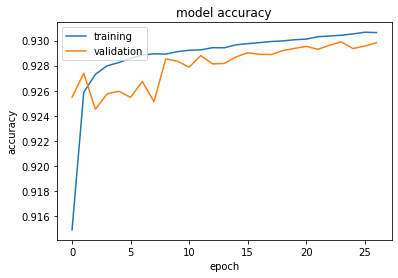

In [76]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

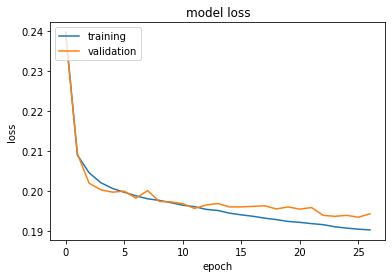

In [77]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

In [78]:
test_generator.reset()
pred=model.predict_generator(test_generator,
steps=STEP_SIZE_TEST,
verbose=1)

18554/18554 [==============================] - 126s 7ms/step


In [79]:
test_generator.reset()
model.evaluate_generator(generator = test_generator, 
                         steps=STEP_SIZE_TEST,
                         verbose=1)

18554/18554 [==============================] - 241s 13ms/step - loss: 0.1959 - accuracy: 0.9289 - top_k_categorical_accuracy: 0.74441s - loss: 0.1959 - accuracy: 0.9289 - top_k_categorical


[0.19587888329168282, 0.92888916, 0.7443678]

In [80]:
model.save('C:/IMDB_mr/Model/')
np.savetxt("preds.csv", pred, delimiter=",")

INFO:tensorflow:Assets written to: C:/IMDB_mr/Model/assets


In [81]:
#pred01 = pred
#pred01[pred01 >= 0.5] = 1
#pred01[pred01 < 0.5] = 0
#np.savetxt("preds01.csv", pred01, delimiter=",")
#print(pred)
#print(pred01)

In [82]:
predicted_class_indices=np.argmax(pred,axis=1)

test_generator.reset()
labels = (test_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())

predictions = [labels[k] for k in predicted_class_indices]

filenames=test_generator.filenames
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})
results.to_csv("results.csv",index=False)
